# Описание проекта



Проведем анализ развлекательного приложения Procrastinate Pro+. 
В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.  
Изучим, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


# Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Предобработка данных


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  
    pd.read_csv('/datasets/orders_info.csv'), 
    pd.read_csv('/datasets/costs_info.csv'), 
)

Просмотрим общую информацию

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Для того, чтобы проверить данные на наличие дубликатов, приведем столбцы к нижнему регистру.

In [6]:
visits.columns=['user_id','region','device','channel','session_start','session_end']
visits['region']=visits['region'].str.lower()
visits['device']=visits['device'].str.lower()
visits['channel']=visits['channel'].str.lower()

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'],format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'],format='%d.%m.%Y %H:%M')

In [8]:
orders.columns=['user_id','event_dt','revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y.%m.%d %H:%M')

In [9]:
costs.columns=['dt','channel','costs']
costs['channel']=costs['channel'].str.lower()
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y.%m.%d').dt.date

In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Проверим есть ли в данных дубликаты

In [10]:
print(visits.duplicated().sum())

0


In [11]:
print(orders.duplicated().sum())

0


In [12]:
print(costs.duplicated().sum())

0


## Исследовательский анализ данных


Создадим пользовательские профили

In [13]:
def get_profiles(visits,orders,ad_costs):
  
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first','device':'first','region':'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(
        0
    )
    return profiles  

 

In [14]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head()) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:00    faceboom     mac  united states   
1   4919697 2019-07-09 12:46:00    faceboom  iphone  united states   
2   6085896 2019-10-01 09:58:00     organic  iphone         france   
3  22593348 2019-08-22 21:35:00  adnonsense      pc        germany   
4  31989216 2019-10-02 00:07:00     yrabbit  iphone  united states   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


Определим минимальную и максимальную дату привлечения клиентов.

In [15]:
min_date = profiles['dt'].min()
max_date =  profiles['dt'].max()
print(min_date, max_date)

2019-05-01 2019-10-27


Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [16]:
reg=profiles.groupby('region').agg({'user_id': 'count'})
reg_payer=profiles.query('payer == True').groupby('region').agg({'user_id': 'count'})
reg_payer.columns=['user_id_payer']
reg_payer=reg.join(reg_payer)
reg_payer['payer_ratio']=reg_payer['user_id_payer']/reg_payer['user_id_payer'].sum()*100
display(reg_payer.sort_values('payer_ratio', ascending=False))

,user_id,user_id_payer,payer_ratio
region,,,
united states,100002,6902,77.716473
uk,17575,700,7.881995
france,17450,663,7.465376
germany,14981,616,6.936156


Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [17]:
dev=profiles.groupby('device').agg({'user_id': 'count'})
dev_payer=profiles.query('payer == True').groupby('device').agg({'user_id': 'count'})
dev_payer.columns=['user_id_payer']
dev_payer=dev.join(dev_payer)
dev_payer['payer_ratio']=dev_payer['user_id_payer']/dev_payer['user_id_payer'].sum()*100
display(dev_payer.sort_values('payer_ratio', ascending=False))

,user_id,user_id_payer,payer_ratio
device,,,
iphone,54479,3382,38.081297
android,35032,2050,23.082986
mac,30042,1912,21.529107
pc,30455,1537,17.306610


(-1.103925067698491,
 1.1001869079856423,
 -1.1270304610084418,
 1.1218493407501375)

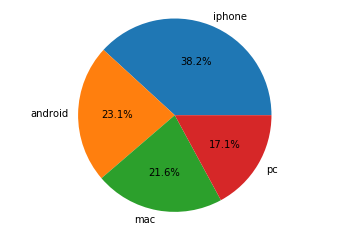

In [18]:
vals = [38, 23, 21.5, 17]
labels = ["iphone", "android", "mac", "pc"]
explode = (0.1, 0, 0.15, 0)
fig, ax = plt.subplots()
ax.pie(vals, labels=labels,autopct='%1.1f%%')
ax.axis("equal")

In [19]:
dev_payer['payer_ratio_per_device']=dev_payer['user_id_payer']/dev_payer['user_id']*100
display(dev_payer.sort_values('payer_ratio_per_device', ascending=False))

,user_id,user_id_payer,payer_ratio,payer_ratio_per_device
device,,,,
mac,30042,1912,21.529107,6.364423
iphone,54479,3382,38.081297,6.207897
android,35032,2050,23.082986,5.851793
pc,30455,1537,17.306610,5.046790


Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [20]:
chan=profiles.groupby('channel').agg({'user_id': 'count'})
chan_payer=profiles.query('payer == True').groupby('channel').agg({'user_id': 'count'})
chan_payer.columns=['user_id_payer']
chan_payer=chan.join(chan_payer)
chan_payer['payer_ratio']=chan_payer['user_id_payer']/chan_payer['user_id_payer'].sum()*100
display(chan_payer.sort_values('payer_ratio', ascending=False))

,user_id,user_id_payer,payer_ratio
channel,,,
faceboom,29144,3557,40.051796
tiptop,19561,1878,21.146267
organic,56439,1160,13.061592
wahoonetbanner,8553,453,5.100777
adnonsense,3880,440,4.954397
rocketsuperads,4448,352,3.963518
leapbob,8553,262,2.950118
opplecreativemedia,8605,233,2.623578
lambdamediaads,2149,225,2.533498


In [21]:
chan_payer['payer_ratio_per_channel']=chan_payer['user_id_payer']/chan_payer['user_id']*100
display(chan_payer.sort_values('payer_ratio_per_channel', ascending=False))

,user_id,user_id_payer,payer_ratio,payer_ratio_per_channel
channel,,,,
faceboom,29144,3557,40.051796,12.204914
adnonsense,3880,440,4.954397,11.340206
lambdamediaads,2149,225,2.533498,10.469986
tiptop,19561,1878,21.146267,9.600736
rocketsuperads,4448,352,3.963518,7.913669
wahoonetbanner,8553,453,5.100777,5.296387
yrabbit,4312,165,1.857899,3.826531
mediatornado,4364,156,1.756559,3.574702
leapbob,8553,262,2.950118,3.063253


**Вывод:** 
Клиентами приложения являются жители CША, Великобритани, Германии и Франции. Большую часть составляют жители США - более 100 тыс пользователей. Среди платящих пользователей также лидером являются жители США - 6902 человек (около 77% от общего числа платящих клиентов). Доля платящих клиентов среди других стран разделена практически поровну в районе 7-8%.

Клиенты приложения пользуются устройствами IPhone, Android, MAC и PC. Лидером устройств среди платящих клиентов является IPhone - более 38%, на втором месте по популярности Android (23%), затем MAC (21%) и PC (17%).

Среди рекламных источников привлечения наиболее выделяется Faceboom	- c его помощью привлечены 40% платящих пользователей. Также выделяются каналы TipTop и Organic - 21% и 13% платящих клиентов соответственно. Меньше всего платящих пользователей пришли из каналов yrabbit и mediatornado - менее 2% из каждого канала.

Также следует отметить, что наибольшая конверсия у пользователей iphone и mac. Среди рекламных каналов высокой конверсией выделяются faceboom,adnonsense и lambdamediaads - 12%, 11% и 10% соответственно. А вот organic обладает наименьшей конверсией - всего 2 %.

## Построим отчёты и посчитаем метрики


Продукт:cколько людей пользуются в день, неделю, месяц?

In [22]:

visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

print(visits.head()) 

        user_id         region   device  channel       session_start  \
0  981449118918  united states   iphone  organic 2019-05-01 02:36:00   
1  278965908054  united states   iphone  organic 2019-05-01 04:46:00   
2  590706206550  united states      mac  organic 2019-05-01 14:09:00   
3  326433527971  united states  android   tiptop 2019-05-01 00:29:00   
4  349773784594  united states      mac  organic 2019-05-01 03:33:00   

          session_end  session_year  session_month  session_week session_date  
0 2019-05-01 02:45:00          2019              5            18   2019-05-01  
1 2019-05-01 04:47:00          2019              5            18   2019-05-01  
2 2019-05-01 15:32:00          2019              5            18   2019-05-01  
3 2019-05-01 00:54:00          2019              5            18   2019-05-01  
4 2019-05-01 03:57:00          2019              5            18   2019-05-01  


In [23]:
dau_total = (
    visits.groupby('session_date').agg({'user_id': 'nunique'}).mean()
)

wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)
mau_total = (
    visits.groupby(['session_year','session_month'])
    .agg({'user_id': 'nunique'})
    .mean()
)

print('Cреднее кол-во пользователей в день:',int(dau_total))
print('Cреднее кол-во пользователей в неделю:',int(wau_total))
print('Cреднее кол-во пользователей в месяц:',int(mau_total))

Cреднее кол-во пользователей в день: 1684
Cреднее кол-во пользователей в неделю: 8353
Cреднее кол-во пользователей в месяц: 28989


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Кол-во людей, использующих приложение, в день')

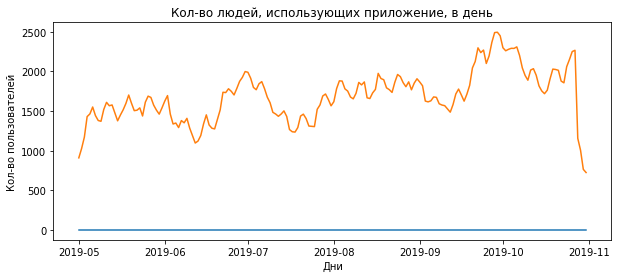

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(visits.pivot_table(index='session_date',values='user_id',aggfunc='nunique'))
plt.xlabel("Дни")
plt.ylabel("Кол-во пользователей")
plt.title("Кол-во людей, использующих приложение, в день")

Text(0.5, 1.0, 'Кол-во людей, использующих приложение, в неделю')

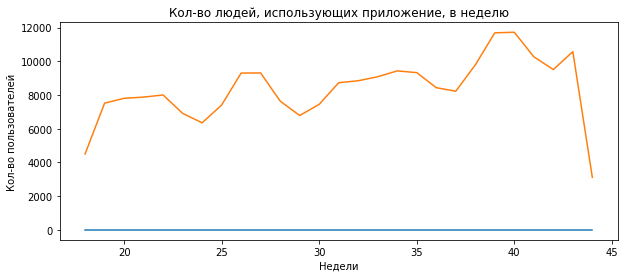

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(visits.pivot_table(index='session_week',values='user_id',aggfunc='nunique'))
plt.xlabel("Недели")
plt.ylabel("Кол-во пользователей")
plt.title("Кол-во людей, использующих приложение, в неделю")

Text(0.5, 1.0, 'Кол-во людей, использующих приложение, в месяц')

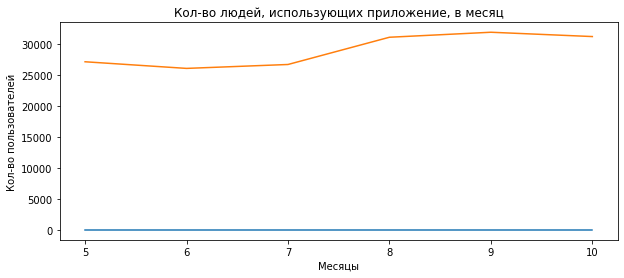

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(visits.pivot_table(index='session_month',values='user_id',aggfunc='nunique'))
plt.xlabel("Месяцы")
plt.ylabel("Кол-во пользователей")
plt.title("Кол-во людей, использующих приложение, в месяц")

**Вывод:**

Среднее кол-во пользователей в день - 1684, в неделю - 8353,в месяц - 28989. По графикам видно, что в целом среднее количество позователей в период с мая по октябрь росло. Наиболее высокий рост заметен в период с июля по август. Если в конце мая количество пользователей в неделю было около 8000 человек, то в конце сентября их было уже больше 11000. Наибольшее число пользователей зафиксировано в начале и в конце месяца, а вот в середине месяца есть провалы.

<div class="alert alert-success">
<b>Комментарий ревьюера v2: </b> Просто супер!</div>

### Изучим число пользовательских сессий

In [27]:
visits['s_start'] = visits['session_start'].astype('str')
visits['u_id'] = visits['user_id'].astype('str')
visits['session_id'] = visits["s_start"] + visits["u_id"]
visits = visits.drop(columns=['s_start', 'u_id'])
display(visits.head())

,user_id,region,device,channel,session_start,session_end,session_year,session_month,session_week,session_date,session_id
0,981449118918,united states,iphone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00,2019,5,18,2019-05-01,2019-05-01 02:36:00981449118918
1,278965908054,united states,iphone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00,2019,5,18,2019-05-01,2019-05-01 04:46:00278965908054
2,590706206550,united states,mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00,2019,5,18,2019-05-01,2019-05-01 14:09:00590706206550
3,326433527971,united states,android,tiptop,2019-05-01 00:29:00,2019-05-01 00:54:00,2019,5,18,2019-05-01,2019-05-01 00:29:00326433527971
4,349773784594,united states,mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00,2019,5,18,2019-05-01,2019-05-01 03:33:00349773784594


In [28]:
sessions_per_user = visits.groupby(['session_year', 'session_date']).agg(
    {'session_id': ['count', 'nunique']}
)

sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
print('Среднее число сессий в день:',sessions_per_user['n_sessions'].mean().astype('int')) 

Среднее число сессий в день: 1684


<div class="alert alert-success">
<b>Комментарий ревьюера: </b> Все отлично сгруппировано и подсчитано.</div>

Построим распределение общего числа сессий в день

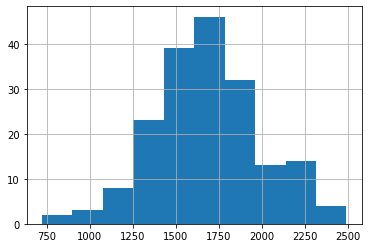

In [29]:
sessions_per_user['n_sessions'].hist()

Узнаем, сколько длится одна сессия

In [30]:
# считаем ASL
visits['session_duration_sec'] = (
    visits['session_end'] - visits['session_start']
).dt.seconds

print('Средняя длительность сессии в день:' , int(visits['session_duration_sec'].median())) 

Средняя длительность сессии в день: 1260


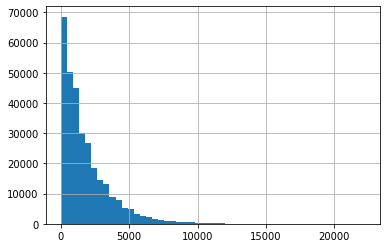

In [31]:
visits['session_duration_sec'].hist(bins=50)
plt.show() 

In [32]:
display(visits['session_duration_sec'].describe())

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_duration_sec, dtype: float64

**Вывод:**

Мы выяснили, что средняя длительность сессии в день - 21 минута, а среднее количество сессий в день - 1684. Таким образом можно сделать вывод, что пользователи, в основном, не просто открывают и закрывают приложение, но и проводят в нем достаточное количество времени.

Продажи: исследуем, сколько времени в среднем проходит с момента первого посещения до покупки.

In [33]:
profiles=profiles.merge(orders)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,event_dt,revenue
0,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:59:09,4.99
1,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172,2019-05-08 06:01:28,4.99
2,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172,2019-05-09 07:34:01,4.99
3,46006712,2019-06-30 03:46:00,adnonsense,android,france,2019-06-30,2019-06-01,True,1.008000,2019-06-30 03:46:52,4.99
4,374052872,2019-08-08 15:42:00,tiptop,mac,united states,2019-08-08,2019-08-01,True,2.972222,2019-08-16 07:44:47,4.99


In [34]:

#дата первой покупки:
first_order_date = (orders.groupby('user_id').agg({'event_dt':'min'})
               .rename(columns={'event_dt':'first_order_date'})
                .reset_index()
              )
 
order_date = profiles.merge(first_order_date)
order_date['order_date'] = (order_date['first_order_date'] - order_date['first_ts']).dt.total_seconds()/60
order_date['order_date'].describe()


count     40212.000000
mean       2555.433216
std        6289.201420
min           0.000000
25%           0.733333
50%           1.366667
75%        2624.633333
max      190314.916667
Name: order_date, dtype: float64

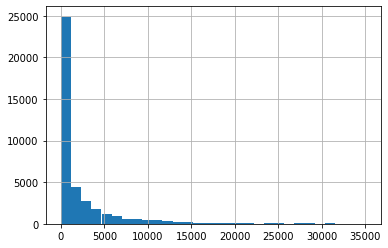

In [35]:
order_date['order_date'].hist(bins=30,range=(0,35000))

In [36]:
print((order_date['order_date'].median()))

1.3666666666666667


В среднем, с момента первого посещения до покупки проходит 1.3 минуты. Возможно, кто-то из 
пользователей, зайдя в приложение первый раз, сначала изучает его (решает нравится ли ему) и лишь 
потом совершает покупку. Либо сталкивается с какими-то сложностями при оплате,и именно поэтому время 
с момента первого входа до покупки может так сильно различаться.


Рассчитаем среднее число покупок на одного покупателя за день, неделю и месяц. 

In [37]:
report=orders.copy()
report['dt']=report['event_dt'].dt.date
report=report.groupby('dt').agg({'user_id':'nunique','event_dt':'count'})
report.columns=['buyers','orders']
report['orders_per_buyer']=report['orders']/report['buyers']
report

,buyers,orders,orders_per_buyer
dt,,,
2019-05-01,25,25,1.0
2019-05-02,29,29,1.0
2019-05-03,44,44,1.0
2019-05-04,56,56,1.0
2019-05-05,58,58,1.0
...,...,...,...
2019-10-27,340,340,1.0
2019-10-28,287,287,1.0
2019-10-29,315,315,1.0


In [38]:
print('Cреднее число покупок на одного покупателя в день:',int( report['orders_per_buyer'].mean()))

Cреднее число покупок на одного покупателя в день: 1


Text(0.5, 1.0, 'Cреднее число покупок на одного пользователя в день')

<Figure size 720x288 with 0 Axes>

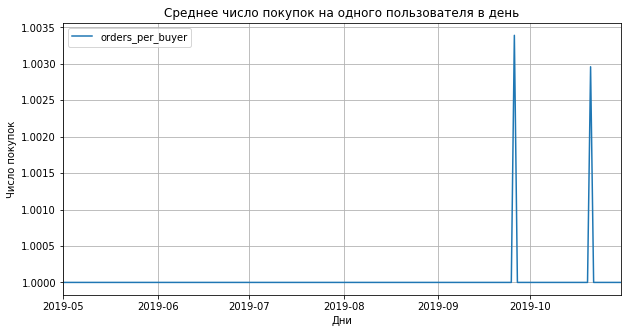

In [39]:
plt.figure(figsize=(10, 4))
report.pivot_table(index='dt',values='orders_per_buyer', aggfunc='mean').plot(grid=True, figsize=(10, 5),)
plt.xlabel("Дни")
plt.ylabel("Число покупок")
plt.title("Cреднее число покупок на одного пользователя в день")

In [40]:
report=orders.copy()
report['dt_week']=report['event_dt'].dt.week
report=report.groupby('dt_week').agg({'user_id':'nunique','event_dt':'count'})
report.columns=['buyers','orders']
report['orders_per_buyer']=report['orders']/report['buyers']
report.head()

,buyers,orders,orders_per_buyer
dt_week,,,
18,156,212,1.358974
19,372,568,1.526882
20,466,706,1.515021
21,574,808,1.407666
22,698,982,1.406877


In [41]:
print('Cреднее число покупок на одного пользователя в неделю:',(report['orders_per_buyer'].mean()))

Cреднее число покупок на одного пользователя в неделю: 1.3266628820826012


Text(0.5, 1.0, 'Cреднее число покупок на одного пользователя в неделю')

<Figure size 720x288 with 0 Axes>

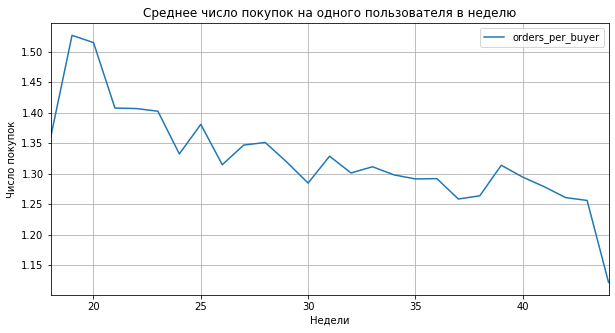

In [42]:
plt.figure(figsize=(10, 4))
report.pivot_table(index='dt_week',values='orders_per_buyer', aggfunc='mean').plot(grid=True, figsize=(10, 5),)
plt.xlabel("Недели")
plt.ylabel("Число покупок")
plt.title("Cреднее число покупок на одного пользователя в неделю")

In [43]:
report=orders.copy()
report['dt_month']=report['event_dt'].dt.month
report=report.groupby('dt_month').agg({'user_id':'nunique','event_dt':'count'})
report.columns=['buyers','orders']
report['orders_per_buyer']=report['orders']/report['buyers']
report.head()

,buyers,orders,orders_per_buyer
dt_month,,,
5,1226,2962,2.415987
6,2130,4875,2.288732
7,2801,6556,2.340593
8,3476,7582,2.181243
9,4124,8430,2.044132


In [44]:
print('Cреднее число покупок на одного пользователя в месяц:',report['orders_per_buyer'].mean())

Cреднее число покупок на одного пользователя в месяц: 2.228447784645054


Text(0.5, 1.0, 'Cреднее число покупок на одного пользователя в месяц')

<Figure size 720x288 with 0 Axes>

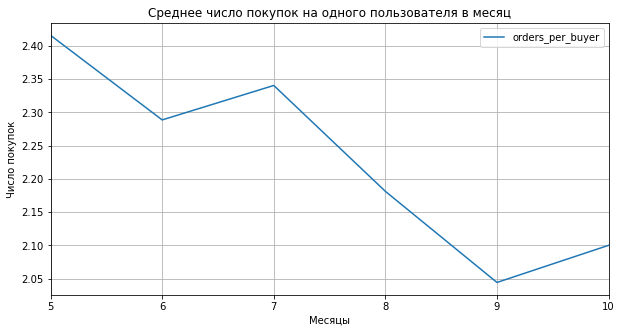

In [45]:
plt.figure(figsize=(10, 4))
report.pivot_table(index='dt_month',values='orders_per_buyer', aggfunc='mean').plot(grid=True, figsize=(10, 5),)
plt.xlabel("Месяцы")
plt.ylabel("Число покупок")
plt.title("Cреднее число покупок на одного пользователя в месяц")

**Вывод:**

Из графиков среднего числа покупок по неделям и месяцам можно сделать вывод, что число покупок в период с мая по октябрь постепенно уменьшалось. Если в мае было больше 2.4 покупок в месяц, то в сентябре всего 2.05 (хотя в октябре немного поднялось). Среднее число покупок в день стабильно равнялось 1, с всплесками в конце сентября и ближе к концу октября.

### Рассчитаем средний чек в день,неделю, месяц.

In [46]:
report=orders.copy()
report['dt']=report['event_dt'].dt.date
report=report.groupby('dt').agg({'revenue':'sum','event_dt':'count'})
report.columns=['revenue','orders']
report['mean_revenue']=report['revenue']/report['orders']
print('Средний чек за день:',report['mean_revenue'].mean())

Средний чек за день: 5.375884247160584


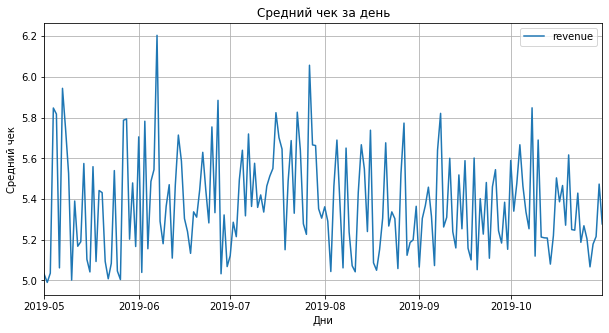

In [47]:
orders['dt']=orders['event_dt'].dt.date
orders.pivot_table(
    index='dt',  values='revenue', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Средний чек')
plt.xlabel('Дни')
plt.title('Cредний чек за день')
plt.show() 

In [48]:
report=orders.copy()
report['dt_week']=report['event_dt'].dt.week
report=report.groupby('dt_week').agg({'revenue':'sum','event_dt':'count'})
report.columns=['revenue','orders']
report['mean_revenue']=report['revenue']/report['orders']
print('Средний чек за неделю:',int(report['mean_revenue'].mean()))

Средний чек за неделю: 5


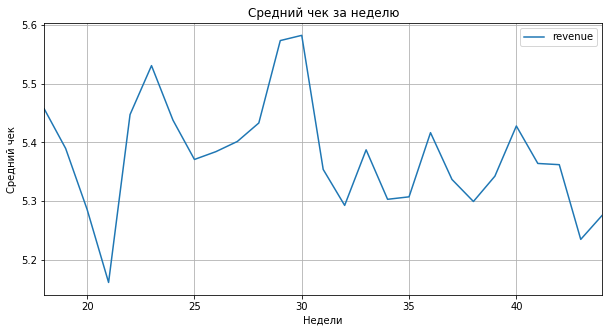

In [49]:
orders['dt_week']=orders['event_dt'].dt.week
orders.pivot_table(
    index='dt_week',  values='revenue', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Средний чек')
plt.xlabel('Недели')
plt.title('Cредний чек за неделю')
plt.show() 

In [50]:
report=orders.copy()
report['dt_month']=report['event_dt'].dt.month
report=report.groupby('dt_month').agg({'revenue':'sum','event_dt':'count'})
report.columns=['revenue','orders']
report['mean_revenue']=report['revenue']/report['orders']
print('Средний чек за месяц:',int(report['mean_revenue'].mean()))


Средний чек за месяц: 5


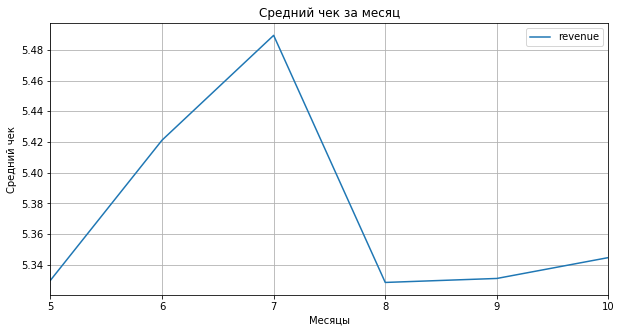

In [51]:
orders['dt_month']=orders['event_dt'].dt.month
orders.pivot_table(
    index='dt_month',  values='revenue', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Средний чек')
plt.xlabel('Месяцы')
plt.title('Cредний чек за месяц')
plt.show() 

**Вывод:**

Из графиков распределения среднего чека за месяц видно, что в июле средний чек подскочил, а в августе резко упал. Затем началось его плавное увеличение до октября. На недельном графике видно, что значение среднего чека сильно скачет. На 21 неделе было минимальное значение - меньше 5.2. А на 30 неделе максимальное значение - практически 5.6.

Маркетинг: cколько денег потратили? Всего / на каждый источник / по времени

In [52]:
print('Общая сумма расходов на маркетинг:', int(costs['costs'].sum()))

Общая сумма расходов на маркетинг: 105497


In [53]:
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
tiptop                54751.30
faceboom              32445.60
wahoonetbanner         5151.00
adnonsense             3911.25
opplecreativemedia     2151.25
rocketsuperads         1833.00
leapbob                1797.60
lambdamediaads         1557.60
mediatornado            954.48
yrabbit                 944.22
Name: costs, dtype: float64

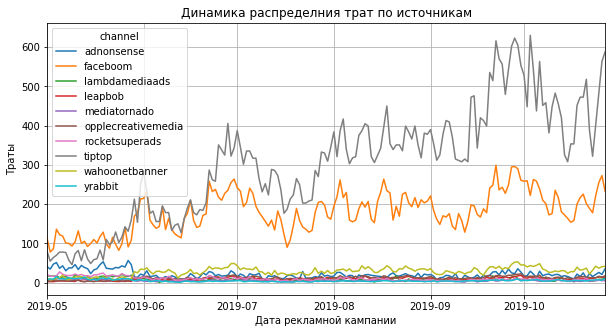

In [78]:
costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Траты')
plt.xlabel('Дата рекламной кампании')
plt.title('Динамика распределния трат по источникам')
plt.show() 

**Вывод:**

Из динамики рапределения трат по источникам видно, что наиболее дорогим рекламным источником являются 
faceboom и tiptop. Траты на них с мая по октябрь выросли больше, чем в 5 раз. Траты на остальные источники все эти месяцы были стабильными.

Расчитаем сколько в среднем стоило привлечение одного пользователя из каждого источника

In [55]:
profiles=get_profiles(visits,orders,costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769


In [56]:

print('Средняя стоимость привлечения одного пользователя для всего проекта:', profiles['acquisition_cost'].mean())

Средняя стоимость привлечения одного пользователя для всего проекта: 0.7032778251826568


In [57]:
#средняя стоимость привлечения одного пользователя в разбивке по источникам
cost_per_channel=profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)
cost_per_channel

channel
tiptop                2.799003
faceboom              1.113286
adnonsense            1.008054
lambdamediaads        0.724802
wahoonetbanner        0.602245
rocketsuperads        0.412095
opplecreativemedia    0.250000
yrabbit               0.218975
mediatornado          0.218717
leapbob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64


Мы расчитали среднюю стоимость привлечения одного пользователя в разбивке по источникам и выяснили, что самым дорогим является привлечение через tiptop (2.79), faceboom (1.11) и adnonsense (1). В тройку самых дешевых рекламных источников вошли yrabbit, meditornado и leapbob - стоимость у всех 0.21.

**Вывод:**
После исследовательского анализа данных можно сделать вывод, что в среднем один пользователь делает одну покупку в день и около 2 покупок в месяц. Наибольшие затраты уходят на рекламу в tiptop и faceboom. Также мы выяснили, что одна сессия длится в среднем около 21 минуты.

## Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии


Функция для расчета удержания

In [58]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

 
    return result_raw, result_grouped, result_in_time 

Функция для расчета конверсии

In [59]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    
    return result_raw, result_grouped, result_in_time 

Функции для расчета LTV и ROI

In [60]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time, 
        roi_grouped,  
        roi_in_time,
    ) 

Функции для визуализации метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

In [61]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [62]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

  
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])


    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

   
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

 
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 


In [63]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [64]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

  

## Оценим окупаемость рекламы для привлечения пользователей


Проанализируем общую окупаемость рекламы.Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по устройствам, странам, рекламным каналам.

In [65]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:00    faceboom     mac  united states   
1   4919697 2019-07-09 12:46:00    faceboom  iphone  united states   
2   6085896 2019-10-01 09:58:00     organic  iphone         france   
3  22593348 2019-08-22 21:35:00  adnonsense      pc        germany   
4  31989216 2019-10-02 00:07:00     yrabbit  iphone  united states   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [66]:
# установим горизонт и момент анализа
observation_date = datetime(2019, 11, 1).date() 
horizon_days = 14  

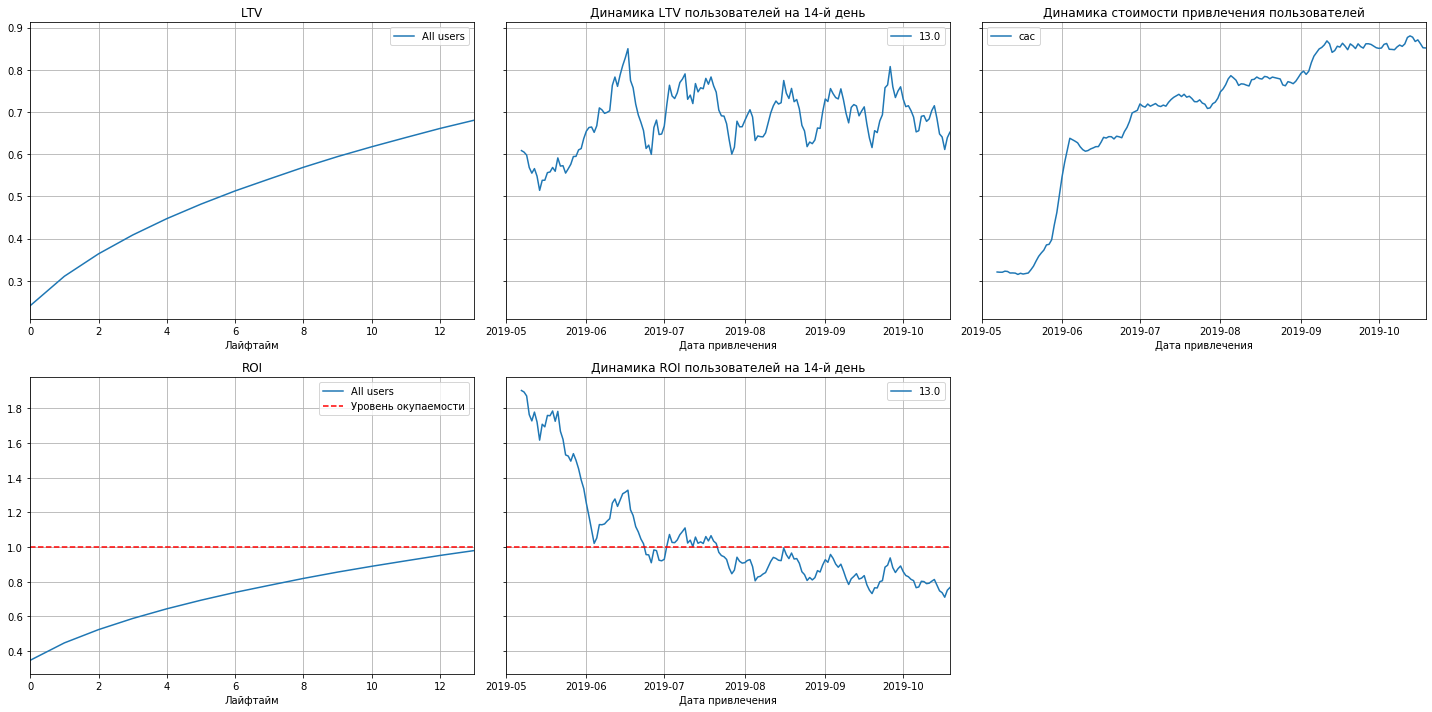

In [67]:
# Рассчитаем и визуализируем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)


plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Реклама не окупается,т.к ROI еще только приближается к уровню окупаемости. Однако на графике динамики видно, что на 14 день ROI постепенно снижается. Уже около 4 месяцев он ниже уровня окупаемости.
CAC рос в течение нескольких месяцев, сейчас стабилен.
LTV стабилен.


Проанализируем окупаемость рекламы с разбивкой по устройствам

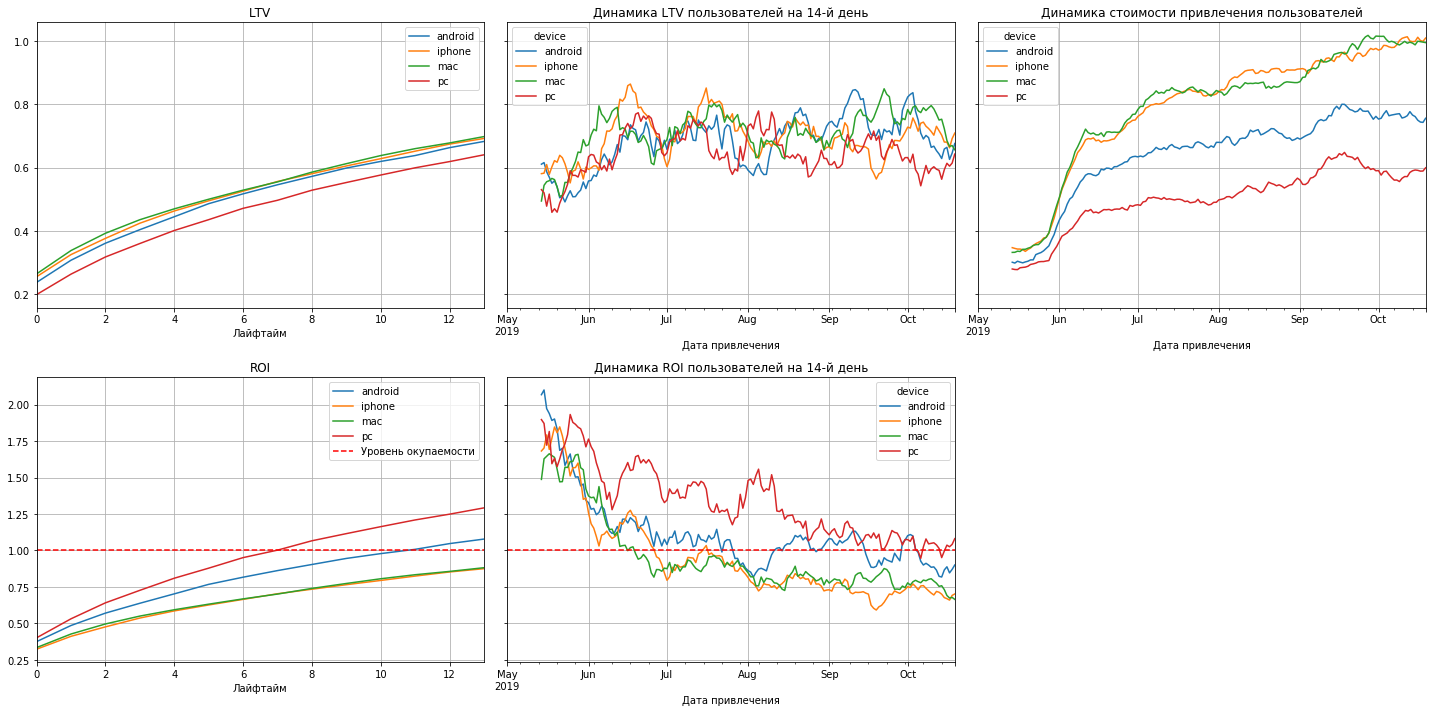

In [68]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

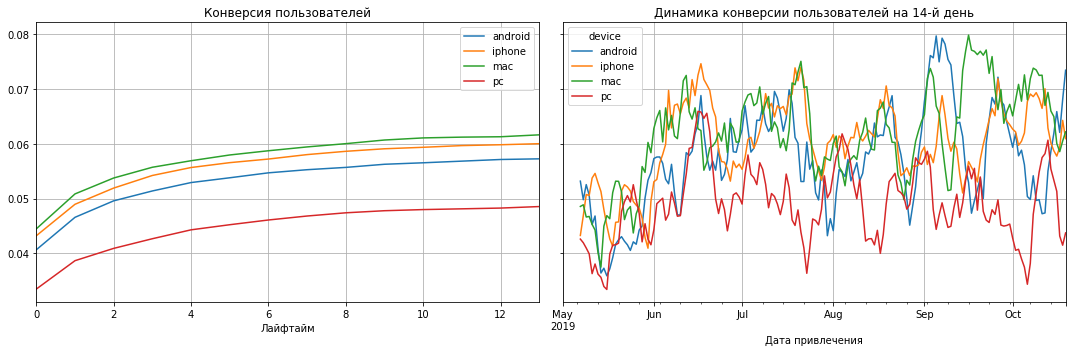

In [69]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

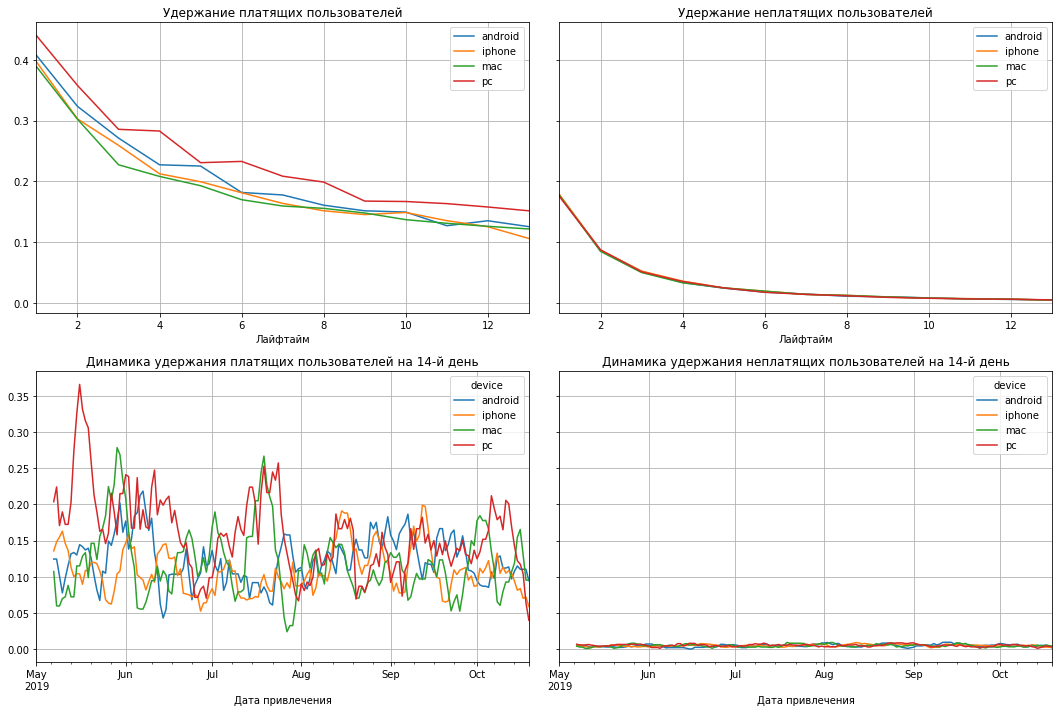

In [70]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days,dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Из графиков можно сделать вывод, что окупаются android и PC, а вот iphone и mac не окупаются. Притом стоимость привлечения у них наиболее высокая. Стоит отметить, что стоимость привлечения пользователей всех девайсов в период с мая по октябрь растет.
По графикам удержания и конверсии в разбивке по устройствам, можно сделать вывод, что конверсия пользователей PC меньше всего, но и удерживаются они лучше, чем пользователи других устройств.

Проанализируем окупаемость рекламы с разбивкой по странам

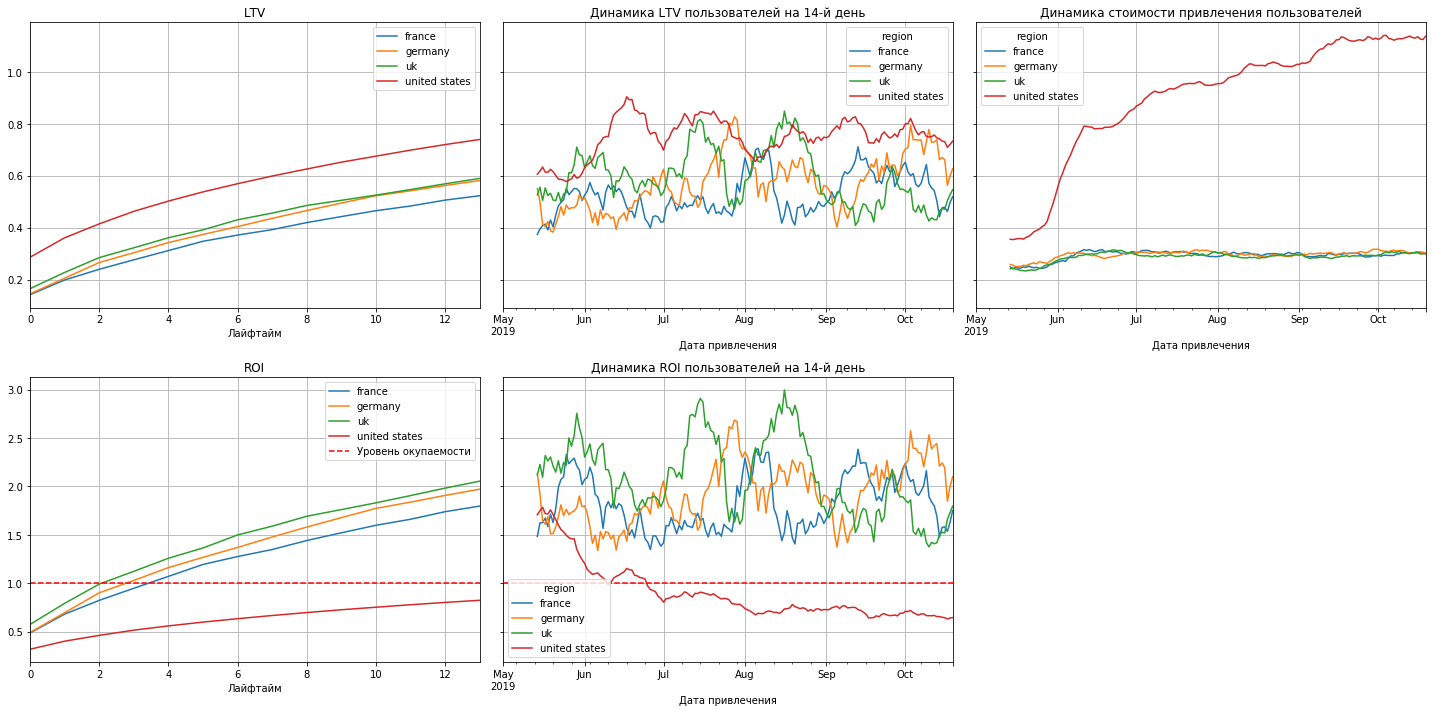

In [71]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

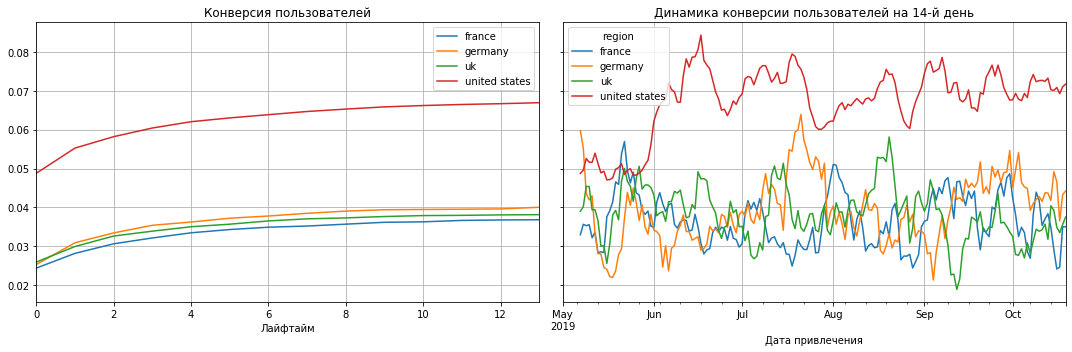

In [72]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

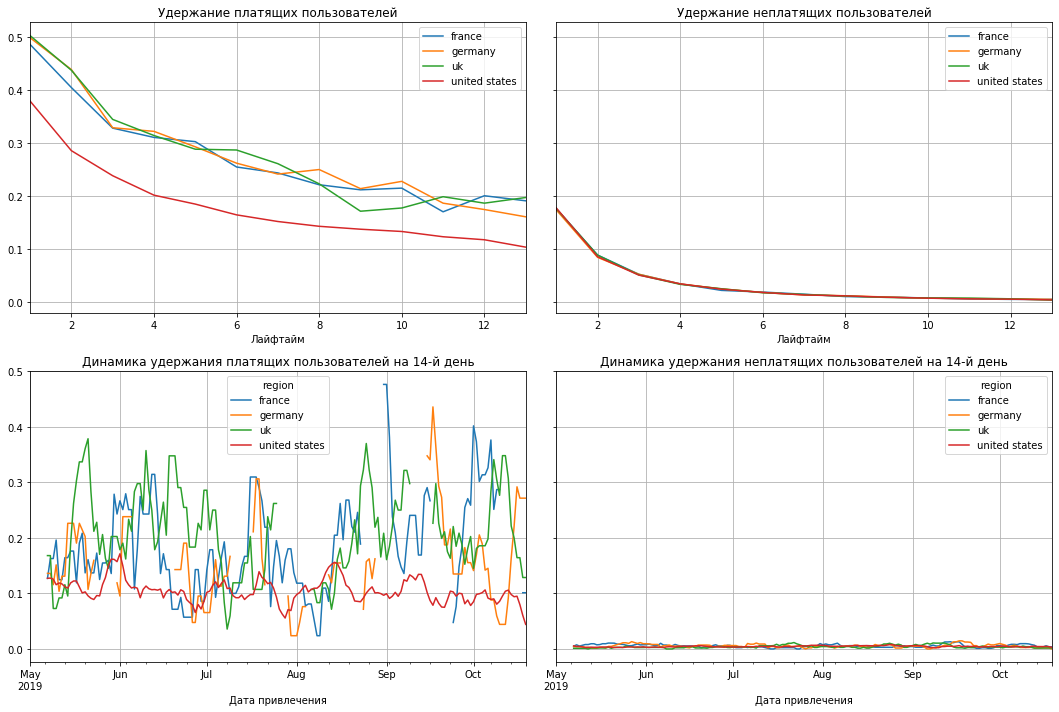

In [73]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days,dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Из графиков видно, что в Германии, Франции и Великобритании стоимость привлечения стабильна и реклама окупается даже в 2 раза. А вот у пользователей из США плохая динамика ROI на 14 день, реклама не окупается (находится на уровне 80%), а стоимость привлечения в несколько раз превышает стоимость привлечения пользователей из других стран.
В разбивке по регионам видно, что конверсия пользователей из США наиболее высокая, а вот удержание платящих пользователей США хуже всего.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

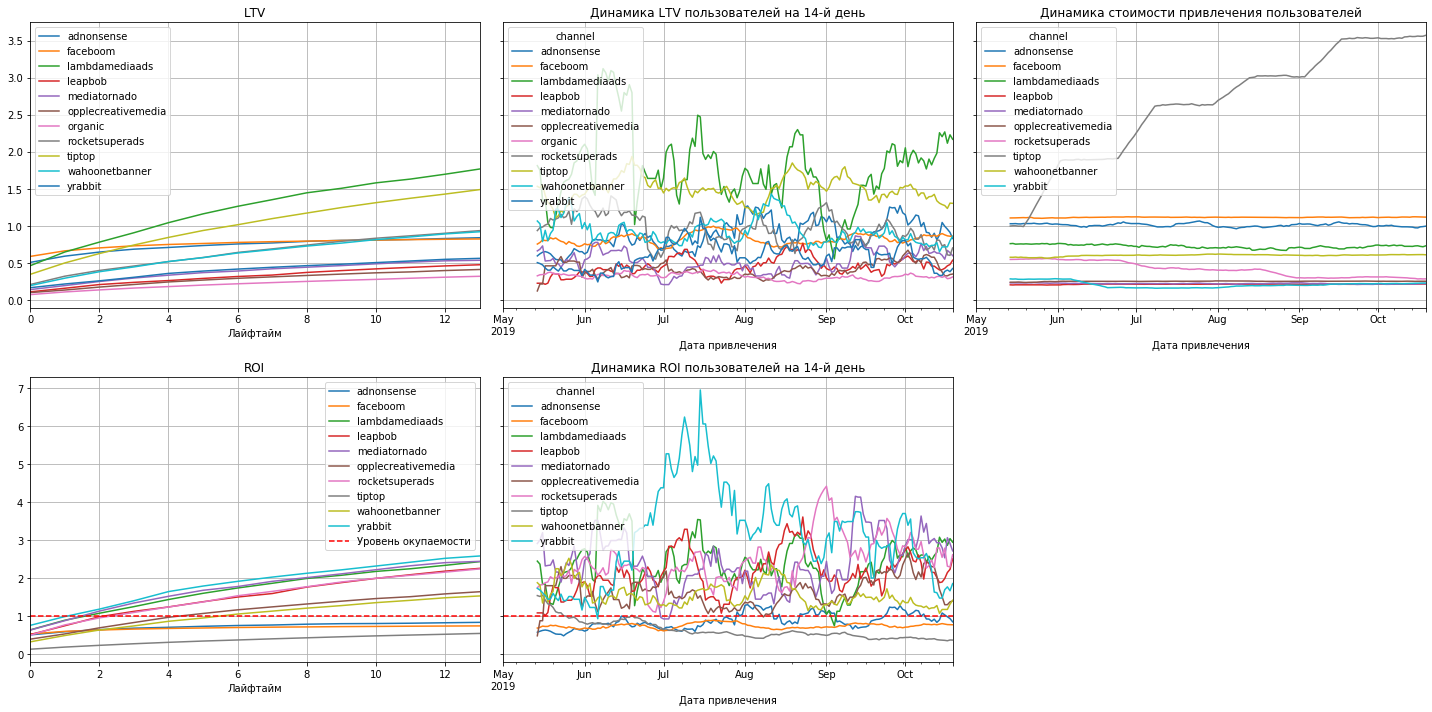

In [74]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

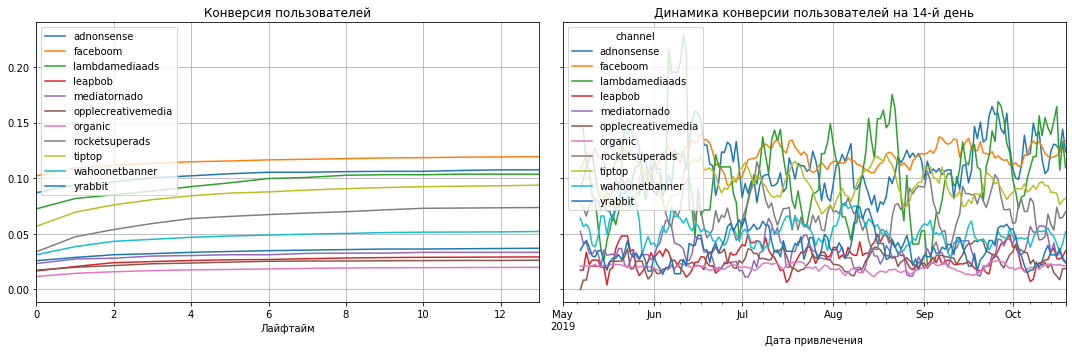

In [75]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

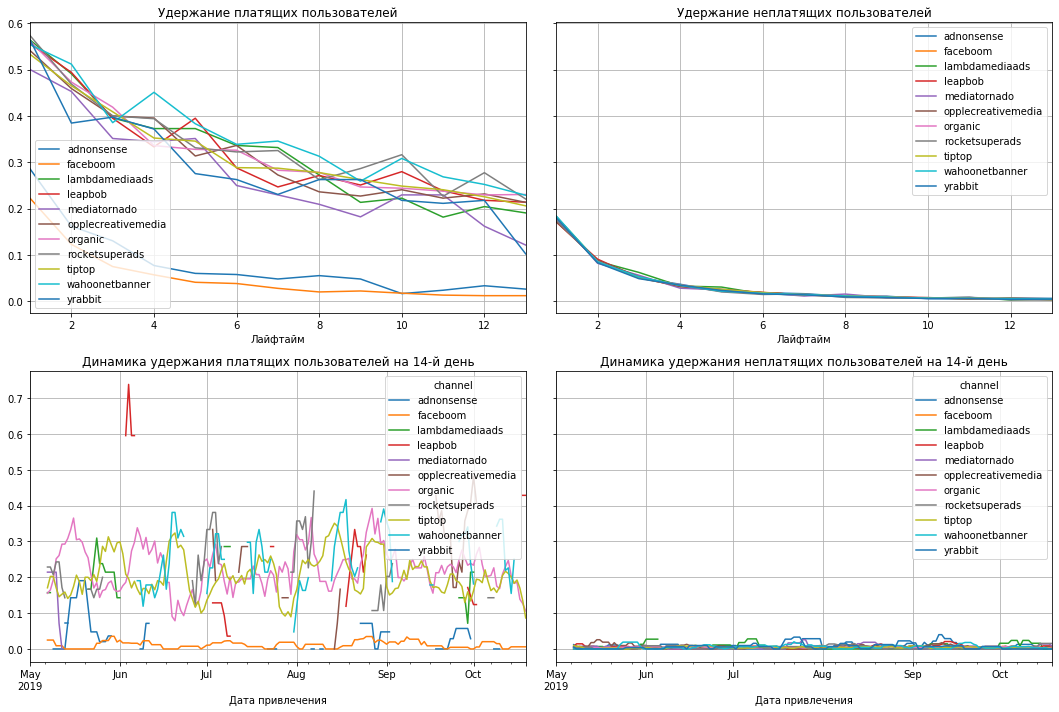

In [76]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days,dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Из графиков видим, что стоимость привлечения пользователей через 'tiptop' выше, чем стоимость привлечения через другие каналы, притом в несколько раз. А вот реклама через него не окупается. На втором месте по стоимости привлечения стоит 'faceboom',но реклама там тоже не окупается. LTV стабилен.
По графикам конверсии и удержания в разбивке по рекламным каналам видим, что удержание пользователей, пришедших из каналов 'faceboom' и 'yrabbit' хуже всего, хотя их конверсия наиболее высокая. До 14 дня пользователи, пришедшие из 'faceboom', практически не доживают.

In [77]:
usa=profiles.query('region == "united states" and channel!="organic"').groupby('channel').agg({'user_id': 'count'})
usa.sort_values('user_id',ascending=False)

,user_id
channel,
faceboom,29144
tiptop,19561
rocketsuperads,4448
mediatornado,4364
yrabbit,4312


По распределению пользователей из США видно, что больше всего людей приходят через faceboom	и tiptop. А ранее мы уже выяснили, что эти каналы самые дорогие и реклама в них не окупается. Из-за этого получается, что и в целом США не окупается.

# Вывод


В ходе работы над проектом, мы сделали следующие выводы:

- Клиентами приложения являются жители CША, Великобритании, Германии и Франции. Большую часть составляют жители США - более 100 тыс пользователей. Среди платящих пользователей также лидером являются жители США - 6902 человек (около 77% от общего числа платящих клиентов). Доля платящих клиентов среди других стран разделена практически поровну в районе 7-8%.

- Клиенты приложения пользуются устройствами IPhone, Android, MAC и PC. Лидером устройств среди платящих клиентов является IPhone - более 38%, на втором месте по популярности Android (23%), затем MAC (21%) и PC (17%).

- Среди рекламных источников привлечения наиболее выделяется Faceboom	- c его помощью привлечены 40% платящих пользователей. Также выделяются каналы TipTop и Organic - 21% и 13% платящих клиентов соответственно. Меньше всего платящих пользователей пришли из каналов yrabbit и mediatornado - менее 2% из каждого канала.

- В среднем один пользователь делает одну покупку в день и около 2 покупок в месяц. 

- Наибольшие затраты уходят на рекламу через tiptop и faceboom.

- Реклама не окупается (ROI еще только приближается к уровню окупаемости).

- Реклама окупается только у пользователей android и PC, а вот iphone и mac не окупаются. Притом стоимость привлечения у них наиболее высокая.
 
- В разбивке по устройствам видно, что в Германии, Франции и Великобритании стоимость привлечения стабильна и реклама окупается даже в 2 раза. А вот у пользователей из США плохая динамика ROI на 14 день, реклама не окупается (находится на уровне 80%), а стоимость привлечения в несколько раз превышает стоимость привлечения пользователей из других стран.

- В разбивке по устройствам видим, что стоимость привлечения пользователей через 'tiptop' выше, чем стоимость привлечения через другие каналы, притом в несколько раз. А вот реклама через него не окупается. На втором месте по стоимости привлечения стоит 'faceboom',но реклама там тоже не окупается. 

- Конверсия пользователей PC наиболее низкая.

- Конверсия пользователей из CША самая высокая, однако у них самое худшее удержание.

- По графикам конверсии и удержания в разбивке по рекламным каналам видим, что удержание пользователей, пришедших из каналов 'faceboom' и 'yrabbit' хуже всего, хотя их конверсия наиболее высокая. До 14 дня пользователи, пришедшие из 'faceboom' практически не доживают.

**Рекомендации**
- Т.к. доля пользователей из США наиболее высокая и там лучшая конверсия, нам нельзя терять этот рынок. Необходимо найти лучшие рекламные источники для этой страны, чтобы реклама окупалась.
- Пересмотреть рекламные каналы. Стоимость привлечения через 'tiptop' и 'faceboom' самая высокая, но реклама там не окупается.
- Изучить почему не окупается реклама у пользователей mac и iphone.